In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 6 (Query Translation - RAG-Fusion)"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 6: RAG-Fusion

![](images/06-rag-fusion.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKNDWQ6BEgCgTcxCiZtPj3mRq8gLt', 'finish_reason': 'stop', 'logprobs': None}, id='run-df5c0736-2b02-40df-a334-87f4a43f9e7d-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from collections import defaultdict
import operator
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.load import dumps, loads
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [15]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [16]:
def reciprocal_rank_fusion(results: list[list[Document]], k: int = 60) -> list[tuple[Document, float]]:
    fused_scores = defaultdict(int)

    for docs in results:
        for rank, doc in enumerate(docs, start=1):
            fused_scores[dumps(doc)] += 1 / (k + rank)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

In [17]:
def format_docs(docs: list[Document]) -> list[str]:
    return "\n\n".join(doc.page_content for doc in docs)

In [18]:
query = "What is task decomposition for LLM agents?"

In [19]:
class State(TypedDict):
    question: str
    generated_questions: list[str]
    retrieved_docs: Annotated[
        list[list[Document]], operator.add
    ]
    context: list[Document]
    context_scores: list[float]
    answer: str

class RetrieverState(TypedDict):
    generated_question: str

In [20]:
def generate_queries(state: State, config: RunnableConfig):
    generated_questions_count = config['configurable'].get("generated_questions_count", 5)
    include_original_question = config['configurable'].get("include_original_question", True)

    questions = []
    query = state["question"]

    if include_original_question:
        questions.append(query)
        
    class MultiQueryGenerator(BaseModel):
        questions: list[str] = Field(
            ..., 
            description="List of questions generated multiple perspectives based on user query", 
            min_items=generated_questions_count, 
            max_items=generated_questions_count
        )

    structured_llm = llm.with_structured_output(MultiQueryGenerator, method="function_calling")
    response = structured_llm.invoke([
        HumanMessage(content=query)
    ])
    questions.extend(response.questions)
    
    return {"generated_questions": questions}


def assign_queries(state: State):
    return [Send("retrieve_docs", {"generated_question": question}) for question in state["generated_questions"]]


def retrieve_docs(state: RetrieverState):
    retrieved_docs = vectorstore.similarity_search(state["generated_question"])
    return {"retrieved_docs": [retrieved_docs]}


def aggregate_docs(state: State):
    retrieved_docs = state["retrieved_docs"]
    reranked_results = reciprocal_rank_fusion(retrieved_docs)
    docs, scores = list(zip(*((doc, score) for doc, score in reranked_results)))
    return {"context": docs, "context_scores": scores}


def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"], context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

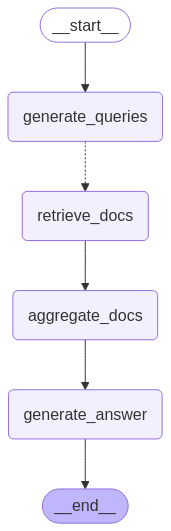

In [21]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_queries", generate_queries)
graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("aggregate_docs", aggregate_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_queries")
graph_builder.add_conditional_edges(
    "generate_queries", assign_queries, ["retrieve_docs"]
)
graph_builder.add_edge("retrieve_docs", "aggregate_docs")
graph_builder.add_edge("aggregate_docs", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()
graph

In [22]:
print(query)

response = graph.invoke(
    {
        "question": query
    }
)

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


/tmp/ipykernel_185389/4149646339.py:9: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_questions': [
        'What is task decomposition for LLM agents?',
        'What are the key components of task decomposition for LLM agents?',
        'How does task decomposition enhance the efficiency of LLM agents?',
        'What are common techniques used in task decomposition for LLM agents?',
        'Can you provide examples of task decomposition in LLM applications?',
        'What challenges are associated with task decomposition in LLM agents?'
    ],
    'retrieved_docs': [[...], [...], [...], [...], [...], [...]],
    'context': (
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...)
    ),
    'context_scores': (
        0.09836065573770493,
        0.08038914490527393,
        0.04787506400409626,
        0.04762704813108039,
        0.04712301587301587,
        0.03149801587301587,
        0.015625,
        0.015625
    ),
    'answer': 'Task decomposition for LLM (large language model) agents refers to the process of breaking down 
larger, complex tasks into smaller, more manageable subgoals. This approach enables the agent to handle complicated
tasks more efficiently by transforming them into a series of simpler steps, which can be addressed individually. 
Task decomposition can be facilitated by various methods, such as using standard prompting techniques like "think 
step by step," providing task-specific instructions, or even incorporating human input. The goal is to create a 
structured approach that allows the LLM agent to navigate through tasks systematically, enhancing both execution 
efficiency and the overall quality of the results.'
}

Task decomposition for LLM (large language model) agents refers to the process of breaking down larger, complex    
tasks into smaller, more manageable subgoals. This approach enables the agent to handle complicated tasks more     
efficiently by transforming them into a series of simpler steps, which can be addressed individually. Task         
decomposition can be facilitated by various methods, such as using standard prompting techniques like "think step  
by step," providing task-specific instructions, or even incorporating human input. The goal is to create a         
structured approach that allows the LLM agent to navigate through tasks systematically, enhancing both execution   
efficiency and the overall quality of the results.

In [23]:
print(query)

config = {
    "configurable": {
        "generated_questions_count": 3,
        "include_original_question": False,
    }
}
response = graph.invoke({"question": query}, config=config)

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_questions': [
        'What are the key principles of task decomposition for LLM agents?',
        'How does task decomposition improve the efficiency of LLM agents?',
        'What are some examples of task decomposition in the context of LLM applications?'
    ],
    'retrieved_docs': [[...], [...], [...]],
    'context': (
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...),
        Document(...)
    ),
    'context_scores': (
        0.04918032786885246,
        0.03225806451612903,
        0.03149801587301587,
        0.03149801587301587,
        0.016129032258064516,
        0.015873015873015872,
        0.015625
    ),
    'answer': 'Task decomposition for LLM agents refers to the process of breaking down complex tasks into smaller,
manageable subgoals. This approach allows the agent to handle difficult tasks more efficiently by transforming them
into a series of simpler steps. The chain of thought (CoT) technique is commonly used for task decomposition, where
the model is prompted to think step by step, facilitating clearer reasoning and better decision-making. By 
decomposing tasks, LLMs can utilize more computational resources at test time, improving their performance and 
providing insight into their thought processes.'
}

Task decomposition for LLM agents refers to the process of breaking down complex tasks into smaller, manageable    
subgoals. This approach allows the agent to handle difficult tasks more efficiently by transforming them into a    
series of simpler steps. The chain of thought (CoT) technique is commonly used for task decomposition, where the   
model is prompted to think step by step, facilitating clearer reasoning and better decision-making. By decomposing 
tasks, LLMs can utilize more computational resources at test time, improving their performance and providing       
insight into their thought processes.